In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np 

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### 실습 1

#### Step 1. 데이터 구성하기 

In [94]:
df_raw = pd.read_csv('/home/piai/PABA_27/BigData/lecture/01 실습파일/2. Big Data 분석/DIABETES.csv')
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [95]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Y            442 non-null    int64  
 1   AGE          442 non-null    int64  
 2   GENDER       442 non-null    int64  
 3   BMI          442 non-null    float64
 4   BP           442 non-null    float64
 5   CHOLESTEROL  442 non-null    int64  
 6   LDL          442 non-null    float64
 7   HDL          442 non-null    float64
 8   TCH          442 non-null    float64
 9   LTG          442 non-null    float64
 10  GLUCOSE      442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [96]:
# GENDER 열의 값 2를 0으로 변환 
df_raw['GENDER'] = df_raw['GENDER'].replace({2:0})
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


- 기존 데이터에서는 GENDER 값이 1과 2로 이루어져 있다. (배수의 관계) 
- replace 함수를 사용하여 dummy 변수로 변환해준다. 
- 이외에 범주형인데 더미화가 되어있지 않거나, 단위와 같이 포함되어 있고 수치형인 변수는 없다.

In [97]:
# 목표 변수, 설명 변수 데이터 지정 
df_raw_y = df_raw['Y']
df_raw_x = df_raw.drop('Y', axis=1, inplace=False)

In [98]:
# train/test dat로 분할 
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=2024)

print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))

train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


#### Step 2. Decisioin Tree 모델 생성 - Parameter 조정/평가 

In [99]:
# 기본 옵션으로 모델 생성 
tree_uncutomized = DecisionTreeRegressor(random_state=2024)
tree_uncutomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력 
print('Score on training set : {:.3f}'.format(tree_uncutomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력 
print('Score on test set : {:.3f}'.format(tree_uncutomized.score(df_test_x, df_test_y)))


Score on training set : 1.000
Score on test set : -0.077


- 모델 설명력은 Train 100%, Test -7%로 모델은 Train 데이터에 과적합되어있다. 
- R^2값은 보통 0과 1사이의 값으로, 값이 음수라는 것은 모델이 실제 값과 예측 값 사이의 차이를 설명하지 못할 뿐만 아니라, 평균 값으로 예측하는 것보다도 못한 성능을 보이고 있다는 뜻이다. 

In [100]:
# 현재 생성된 트리 모델의 옵션 확인 
tree_uncutomized.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2024,
 'splitter': 'best'}

##### 모델 Parameter 조정 - 분리 노드의 최소 자료 수 변경 

In [101]:
# train 및 test 설명력 결과 저장 
train_score = []
test_score = []
# min_samples_leaf 
para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state=2024, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장 
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [102]:
# 모델 설명력 확인 
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,-0.077
1,2,0.950,-0.137
2,3,0.889,-0.016
3,4,0.832,0.011
4,5,0.776,0.005
5,6,0.727,0.041
6,7,0.695,0.041
7,8,0.678,0.074
8,9,0.663,0.154
9,10,0.639,0.254


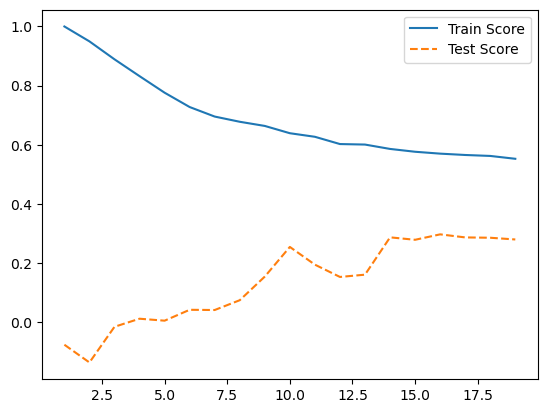

In [103]:
# 모델 설명력 그래프 확인 
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')
plt.plot(para_leaf, test_score, linestyle='--', label='Test Score')
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델은 설명력은 감소한다. 
- Train/Test 데이터의 성능 변화를 고려하여 9를 선택한다.
- Test 데이터의 성능 변화를 고려하면 13이나 그 이후 숫자를 선택할 수 있지만 Train 데이터의 성능이 많이 저하된다. 

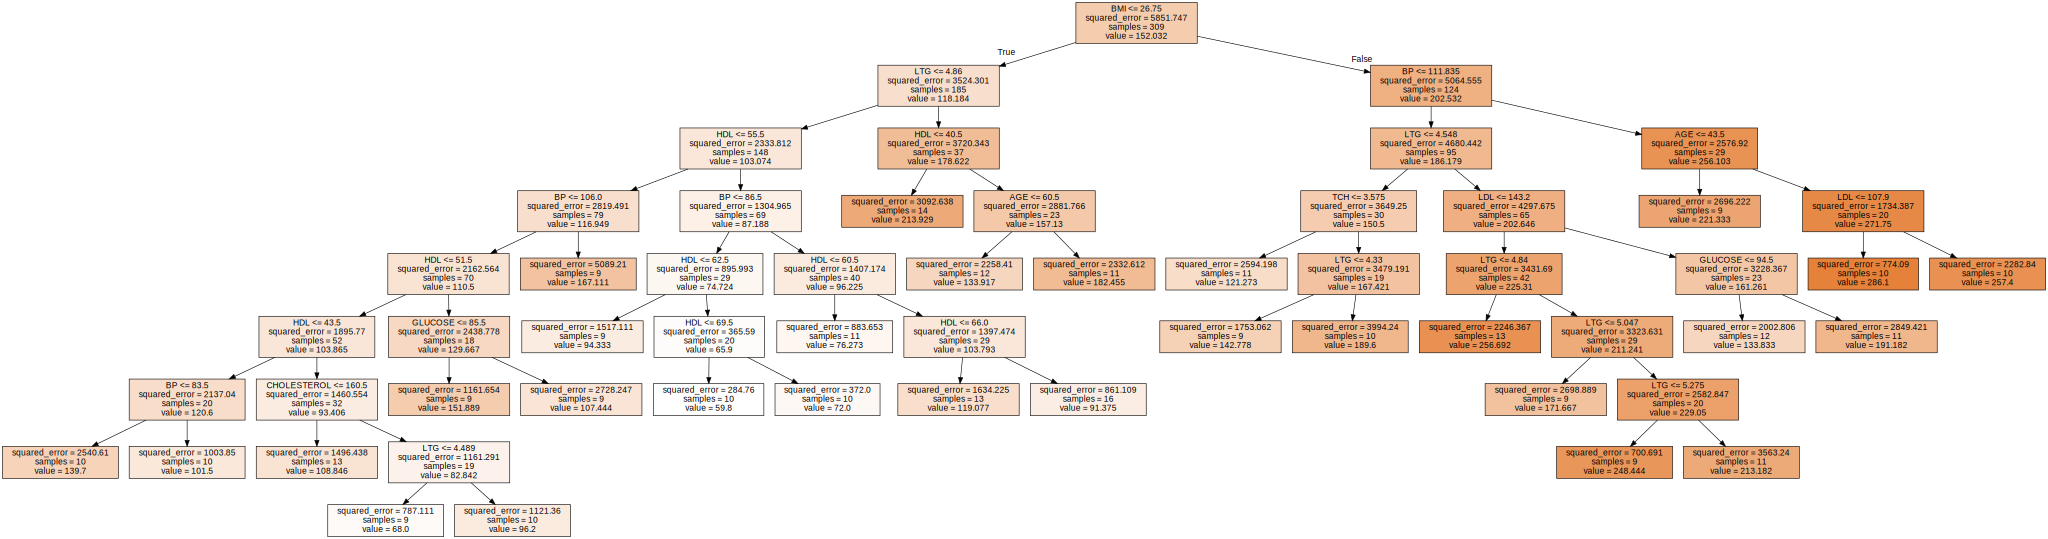

In [104]:
# 변수명 저장 
v_feature_name = df_train_x.columns
# 노드의 최소 자료 수=9 모델
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_leaf.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

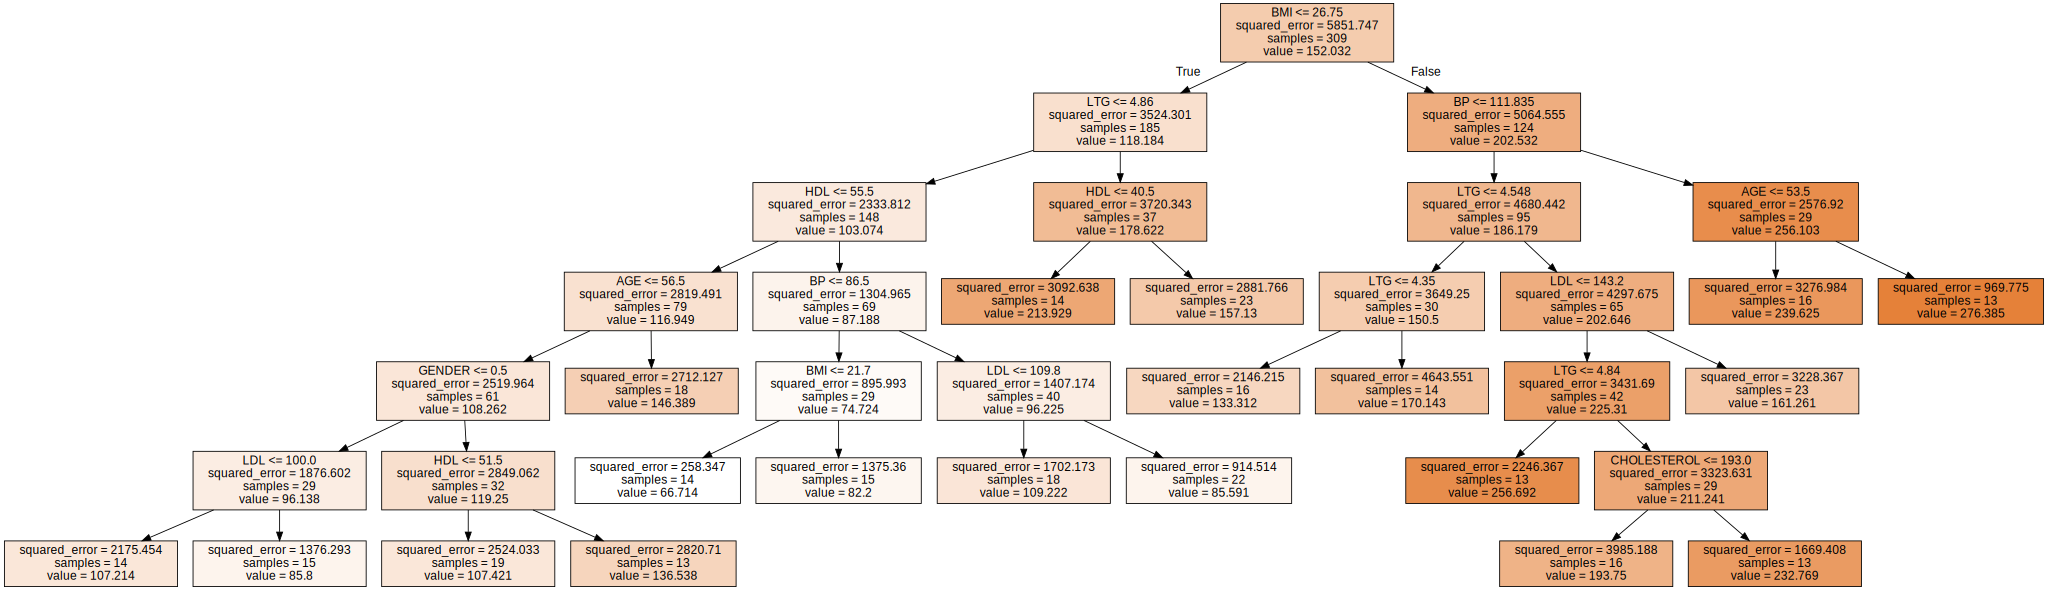

In [105]:
# 노드의 최소 자료 수=13 모델 
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=13)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_leaf.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

##### 모델 Parameter 조정 - 분리 노드의 최소 자료 수 변경 

In [106]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split 
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [107]:
# 모델 설명력 확인 
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.663,0.154
1,6,0.663,0.154
2,8,0.663,0.154
3,10,0.663,0.154
4,12,0.663,0.154
5,14,0.663,0.154
6,16,0.663,0.154
7,18,0.663,0.154
8,20,0.651,0.184
9,22,0.641,0.212


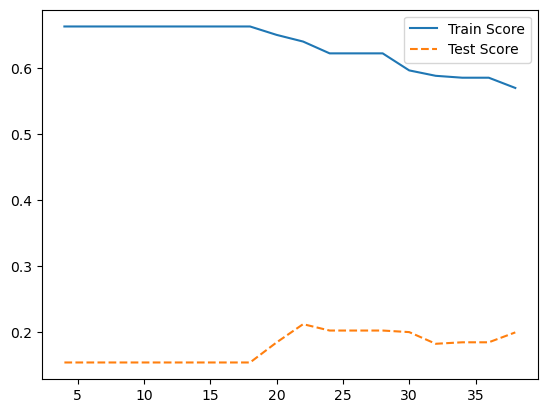

In [108]:
# 모델 설명력 그래프 확인 
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, test_score, linestyle='--', label='Test Score')
plt.legend()

- 분리 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 
- Train/Test 데이터의 성능 변화를 고려하여 9를 선택한다.

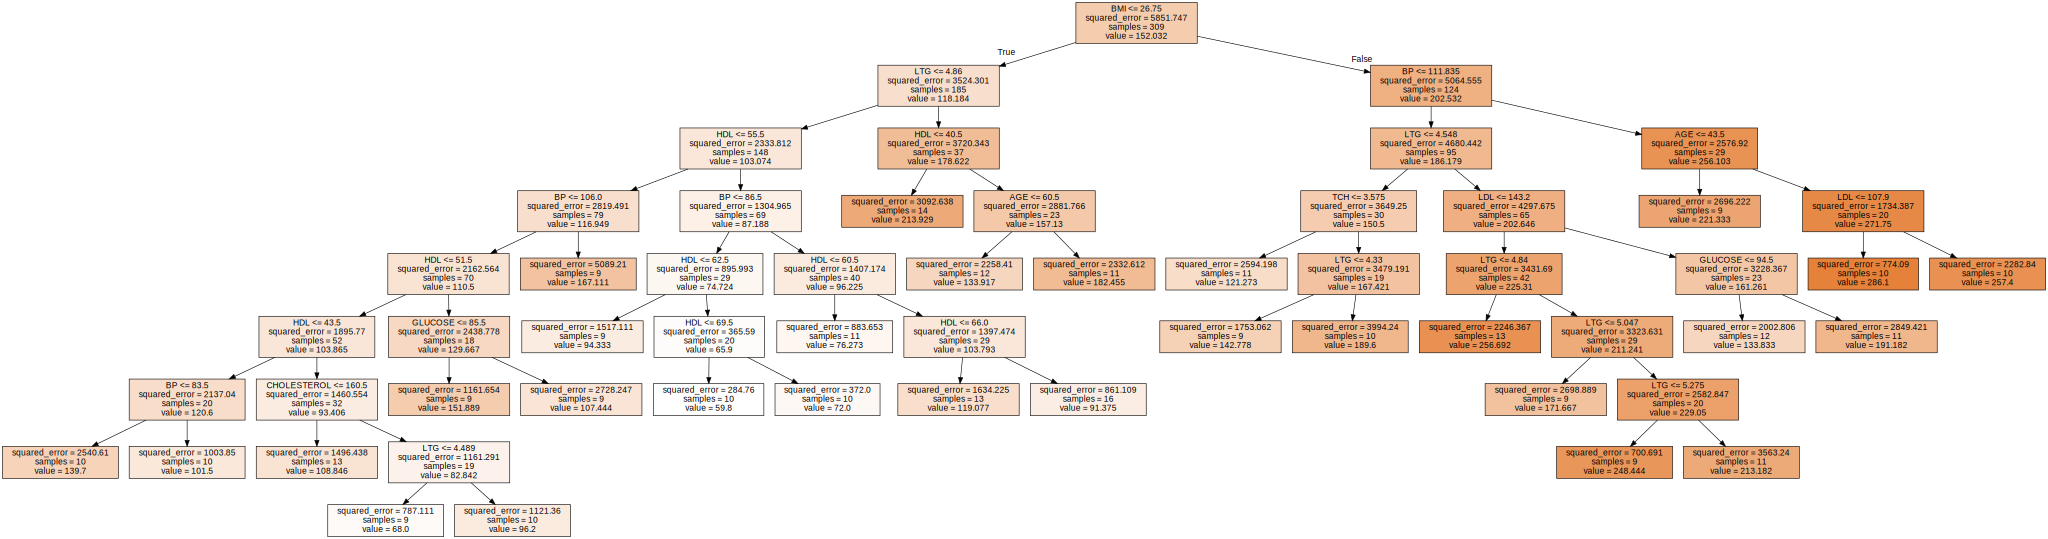

In [109]:
# 분리 노드의 최소 자료 수=9 모델 
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_split.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

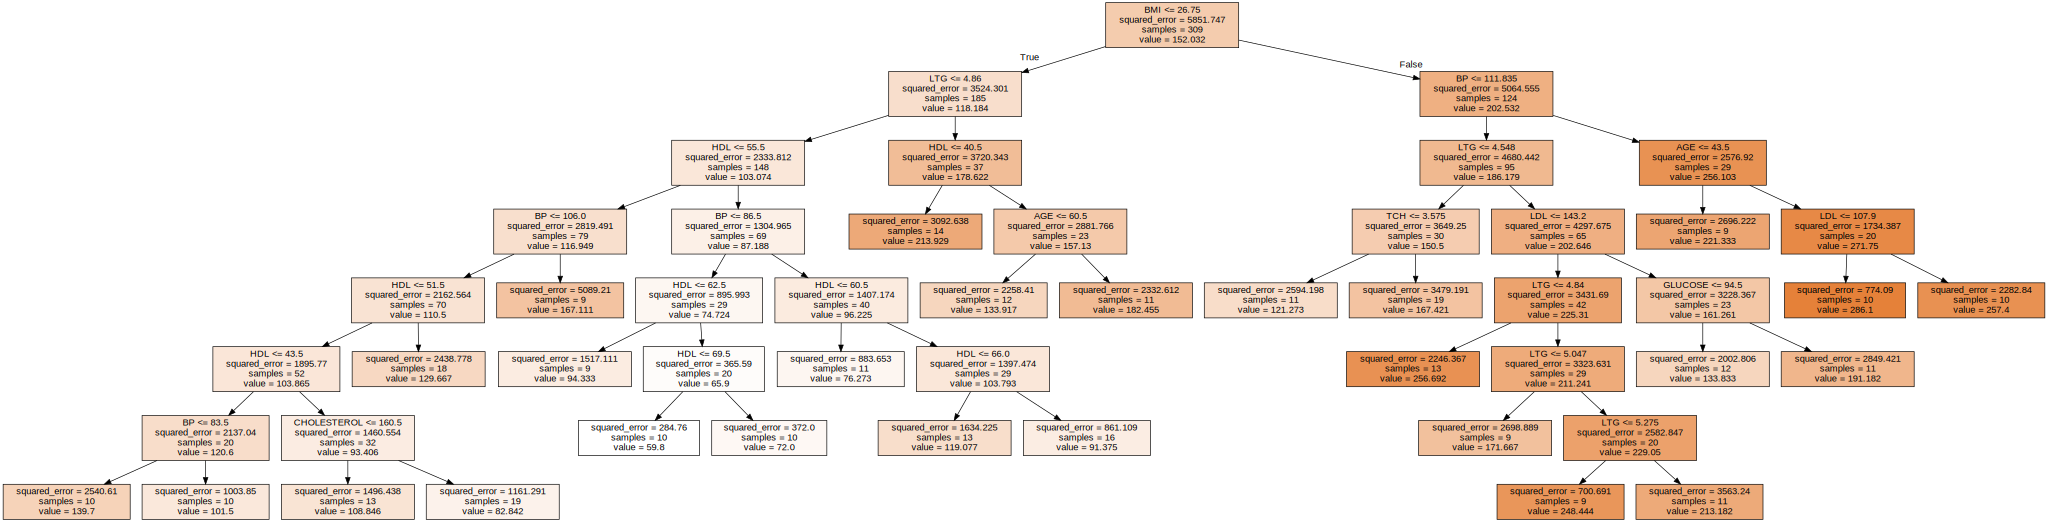

In [110]:
# 분리 노드의 최소 자료 수=20 모델
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_split.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

##### 모델 Parameter 조정 - 최대 깊이 변경

In [111]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# max_depth
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9, max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [112]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.292,0.194
1,2,0.446,0.276
2,3,0.519,0.327
3,4,0.589,0.275
4,5,0.626,0.205
5,6,0.651,0.185
6,7,0.661,0.149
7,8,0.663,0.154
8,9,0.663,0.154
9,10,0.663,0.154


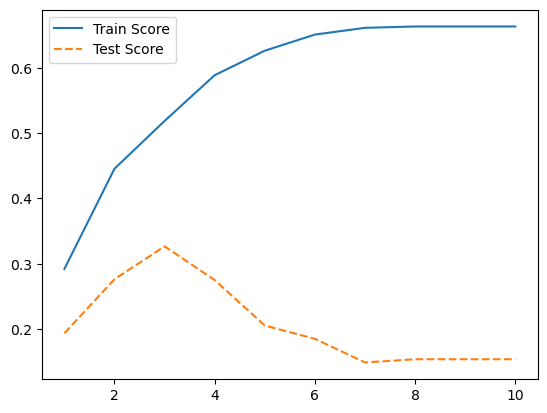

In [113]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, test_score, linestyle='--', label='Test Score')
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가한다. 
- Train/Test 데이터의 성능 변화를 고려하여 2를 선택한다.

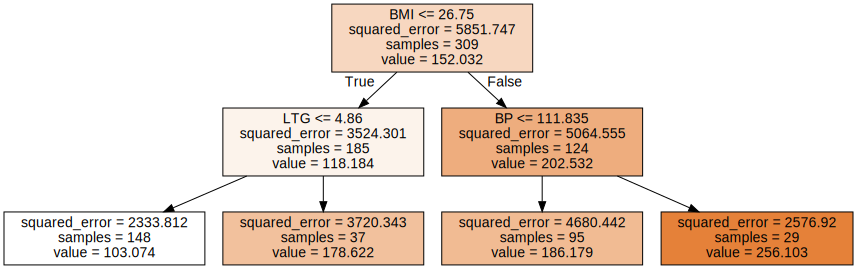

In [114]:
# 최대 깊이=2 모델 
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9, max_depth=2)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_depth.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

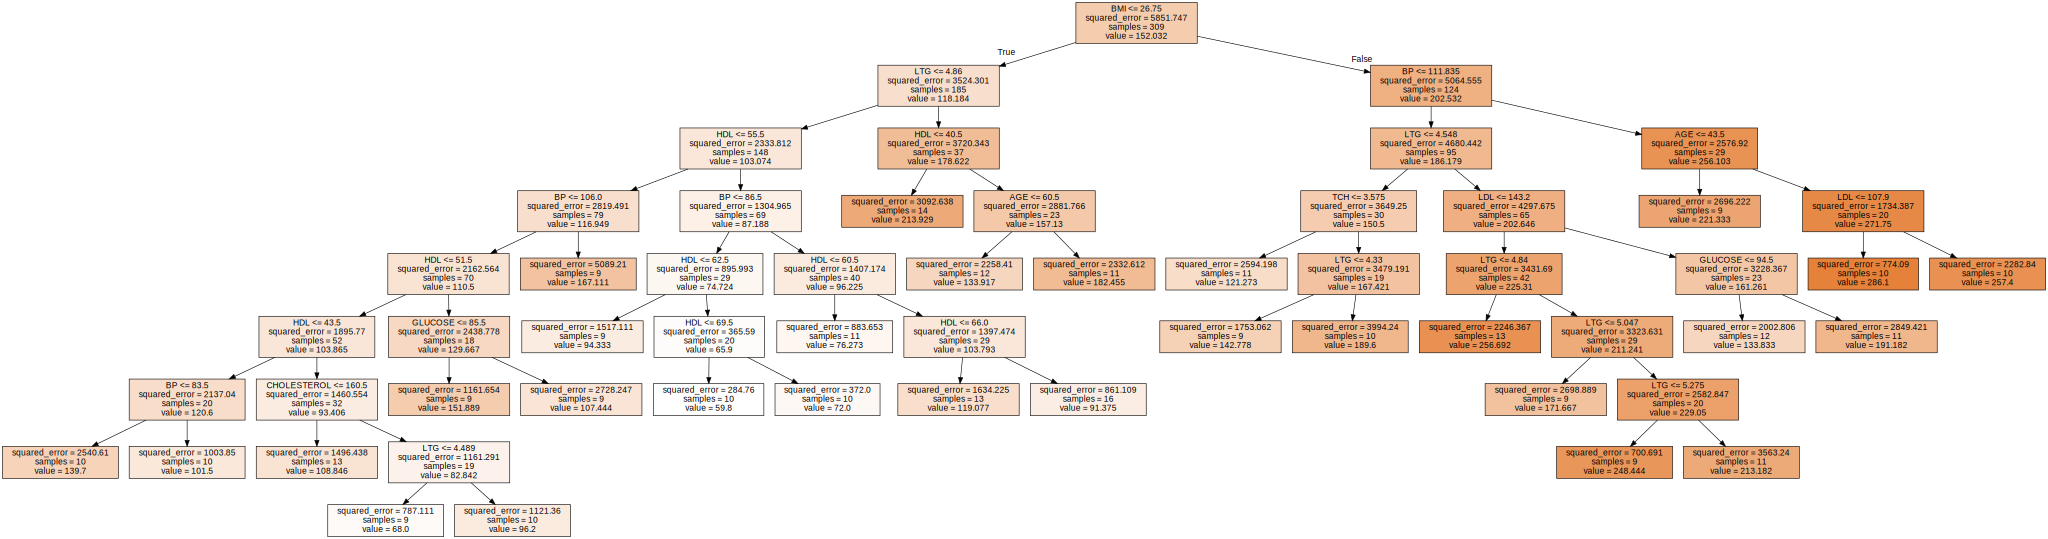

In [115]:
# 최대 깊이=8 모델
tree_graph = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9, max_depth=8)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file='tree_depth.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### Step 3. 최종 모델 선정/시각화

In [116]:
v_feature_name = df_train_x.columns
# min_samples_leaf=9, min_samples_split=9, max_depth=2
tree_final = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9, max_depth=2)
tree_final.fit(df_train_x, df_train_y)
tree_final.get_params()

# Test 데이터에 대한 실제값과 예측값 확인 
test_pred = tree_final.predict(df_test_x)
print('test data의 실제값: \n', df_test_y[:10])
print('test data의 예측값: \n', test_pred[:10])

test data의 실제값: 
 334     72
313    163
133     83
152    292
250    303
320    122
66     150
35     102
161    217
149    126
Name: Y, dtype: int64
test data의 예측값: 
 [103.07432432 186.17894737 103.07432432 178.62162162 256.10344828
 186.17894737 103.07432432 178.62162162 256.10344828 178.62162162]


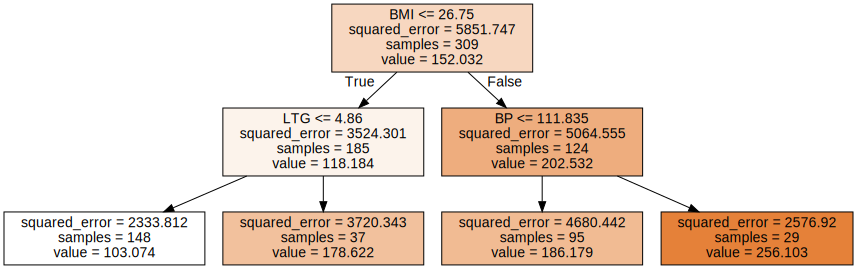

In [117]:
# 최종 모델 시각화 
export_graphviz(tree_final, out_file='tree_final.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

- 트리 분리에 영향이 큰 변수는 BMI, LTG, BP이다. 
- BMI <= 26.75이면 True (자료 수=185, Y(당뇨병) 평균이 감소(152.032->118.184)하고 MSE는 감소), BMI > 26.75이면 False (자료 수=124, Y(당뇨병) 평균이 증가(152.032->202.532)하고 MSE는 감소)로 분리된다. 
    - 이후 분리 조건의 좌측이 True, 우측이 False로 적용된다.
- 최대 깊이가 증가하면서 생성되는 잎사귀(Leaf)의 자료 수는 감소하고 모델의 MSE 또한 지속적으로 감소하지만, 분리 조건에 따라 Y(당뇨병)은 상위 노드 대비 증가하거나 감소한다. 

#### Step 4. 결론 도출 

In [118]:
# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

# 테이블을 중요도별로 정렬 
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.656
8,LTG,0.210
3,BP,0.135
0,AGE,0.000
1,GENDER,0.000
4,CHOLESTEROL,0.000
5,LDL,0.000
6,HDL,0.000
7,TCH,0.000
9,GLUCOSE,0.000


Text(0, 0.5, '변수')

/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-pack

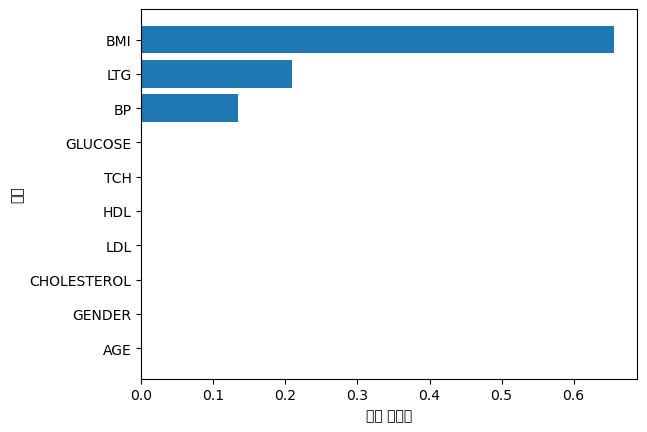

In [119]:
# 설명변수 중요도 그래프 
# 중요도 높은 변수를 상위에 그림 
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

### 실습 2

#### Step 2. Random Forest 모델 생성 - Parameter 조정/평가

In [120]:
# 기본 옵션으로 모델 생성 
rf_uncustomized = RandomForestRegressor(random_state=2024)
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print('Score on training set : {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print('Score on test set : {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.918
Score on test set : 0.418


- 모델 설명력은 Train 91.8%, Test 41.8%로 모델은 Train 데이터에 과대적합이다.

In [121]:
# 현재 생성된 랜덤 포레스트 모델의 옵션 확인
rf_uncustomized.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2024,
 'verbose': 0,
 'warm_start': False}

##### 모델 Parameter 조정 - 트리 수 변경

In [122]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# n_estimators
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(random_state=2024, n_estimators=v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

In [123]:
# 모델 설명력 확인 
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.894,0.390
1,20,0.908,0.395
2,30,0.914,0.402
3,40,0.916,0.408
4,50,0.914,0.404
5,60,0.916,0.407
6,70,0.917,0.412
7,80,0.919,0.415
8,90,0.919,0.415
9,100,0.918,0.418


Text(0.5, 0, 'n_estimators')

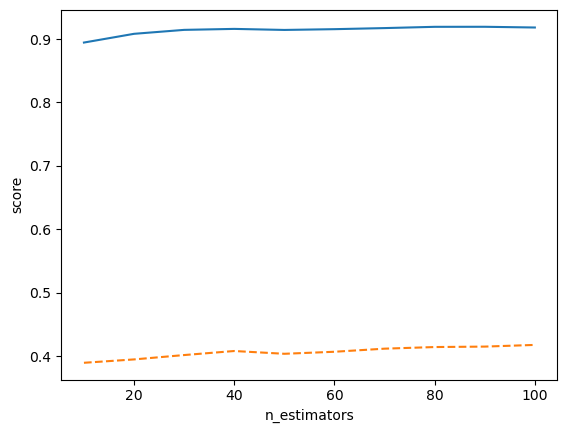

In [124]:
# 모델 설명력 그래프 확인 
plt.plot(para_n_tree, train_score, linestyle='-', label='Train Score')
plt.plot(para_n_tree, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')

- 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가한다. 
- 트리 수가 40개를 초과해도 설명력은 거의 향상되지 않는다. 
- 최대 트리 수에 따른 영향을 배제하고 다른 파라미터의 영향을 확인하고자 100을 선택하고 다른 파라미터를 변경해보았다. 

##### 모델 Parameter 조정 - 잎사귀 노드의 최소 자료 수 변경 

In [125]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=2024, n_estimators=100, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [126]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.918,0.418
1,2,0.885,0.421
2,3,0.838,0.432
3,4,0.796,0.430
4,5,0.757,0.432
5,6,0.729,0.437
6,7,0.701,0.444
7,8,0.680,0.446
8,9,0.662,0.448
9,10,0.648,0.450


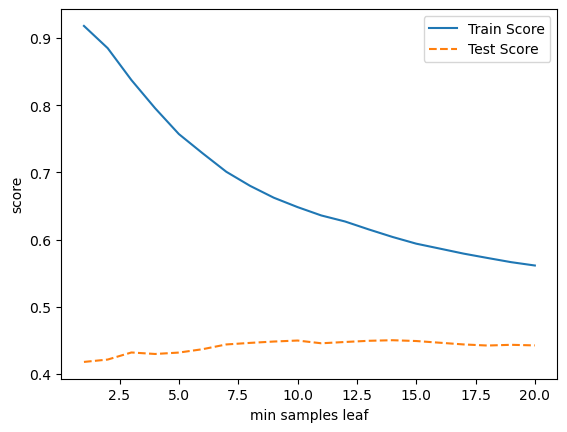

In [127]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')
plt.plot(para_leaf, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('min samples leaf')
plt.legend()

- 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 
- Test 데이터의 정확도 변화를 고려하여 9를 선택한다. 

##### 모델 Parameter 조정 - 분리 노드의 최소 자료 수 변경

In [128]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split
para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=2024, n_estimators=100, min_samples_leaf=11, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [129]:
# 모델 설명력 확인 
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.636,0.446
1,6,0.636,0.446
2,8,0.636,0.446
3,10,0.636,0.446
4,12,0.636,0.446
5,14,0.636,0.446
6,16,0.636,0.446
7,18,0.636,0.446
8,20,0.636,0.446
9,22,0.636,0.446


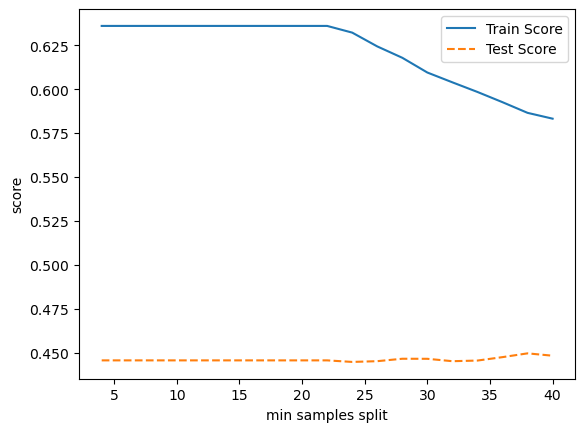

In [130]:
# 모델 설명력 그래프 확인 
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('min samples split')
plt.legend()

- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 
- Train/Test 데이터의 성능 변화를 고려하여 9를 선택한다. 

##### 모델 Parameter 조정 - 최대 깊이 변경

In [131]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# max_depth
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=2024, n_estimators=100, min_samples_leaf=11, min_samples_split=22, max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [132]:
# 모델 설명력 확인 
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.393,0.366
1,2,0.512,0.435
2,3,0.576,0.449
3,4,0.614,0.448
4,5,0.632,0.447
5,6,0.636,0.446
6,7,0.636,0.446
7,8,0.636,0.446
8,9,0.636,0.446
9,10,0.636,0.446


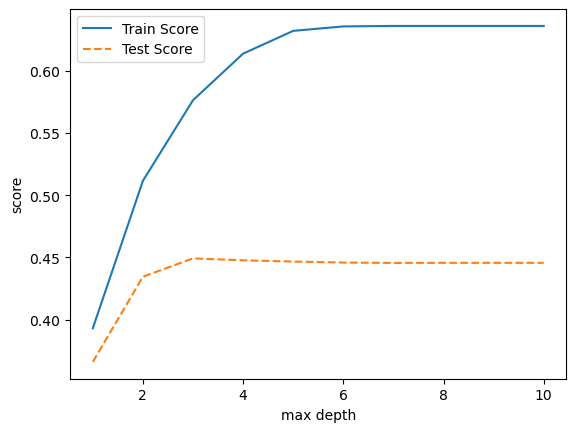

In [133]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가한다. 
- Train/Test 데이터의 정확도 변화를 고려하여 5를 선택한다. 

#### Step 3. 최종 모델 선정/시각화

In [134]:
# 최종 모델 생성 
# n_estimators=100, min_samples_leaf=9, min_samples_split=9, max_depth=5
rf_final = RandomForestRegressor(random_state=2024, n_estimators=100, min_samples_leaf=9, min_samples_split=9, max_depth=5)
rf_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print('Score on training set : {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print('Score on test set : {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set : 0.652
Score on test set : 0.448


In [135]:
# Test 데이터에 대한 실제값과 예측값 확인
test_pred = rf_final.predict(df_test_x)
print('test data의 실제값: \n', df_test_y[:10])
print('test data의 예측값: \n', test_pred[:10])

test data의 실제값: 
 334     72
313    163
133     83
152    292
250    303
320    122
66     150
35     102
161    217
149    126
Name: Y, dtype: int64
test data의 예측값: 
 [103.3573347  239.36855743  96.10556355 195.92617252 262.91983031
 174.07854055 125.82368443 141.82432169 250.68501628 179.59559337]


In [136]:
# 파라미터 값 확인 
rf_final.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2024,
 'verbose': 0,
 'warm_start': False}

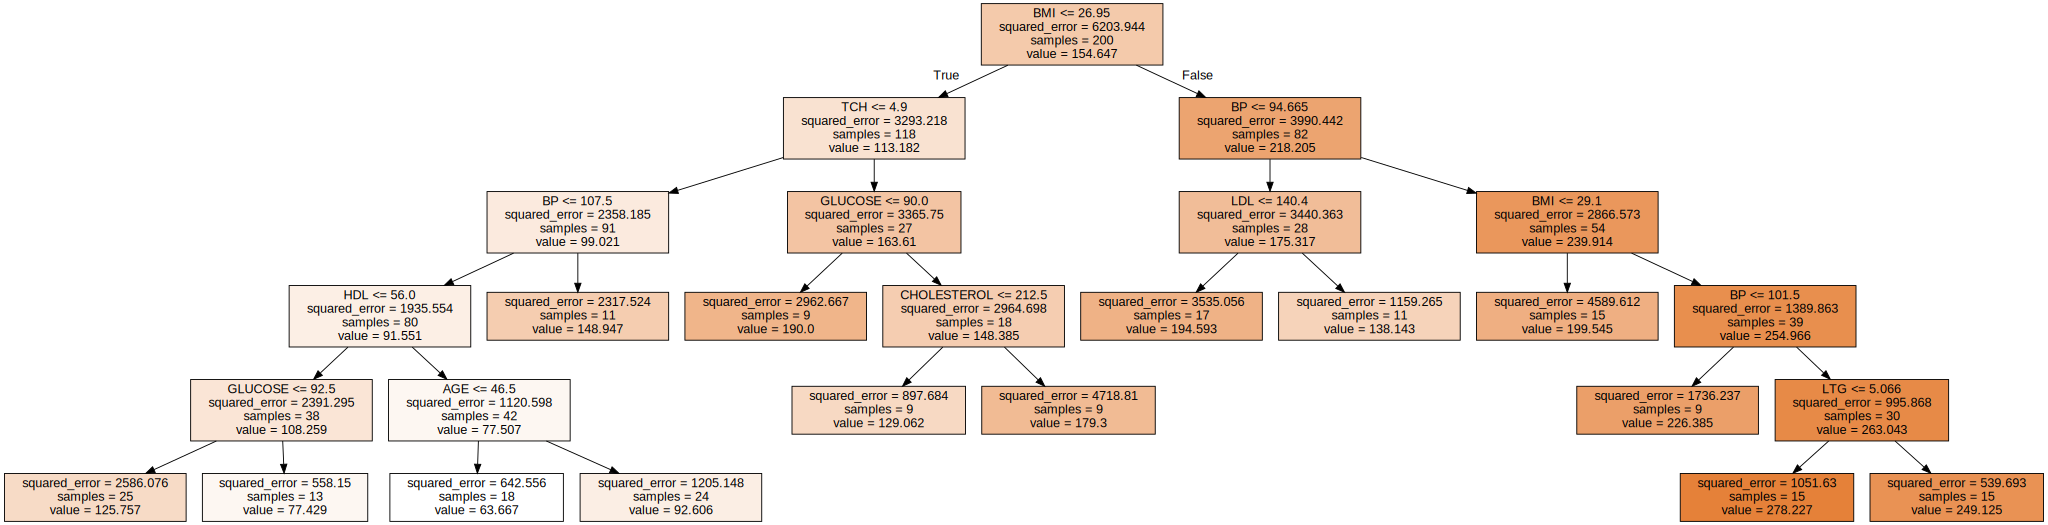

In [137]:
# 최종 모델 시각화  
# 0번 트리 
v_feature_name = df_train_x.columns
export_graphviz(rf_final.estimators_[0], out_file='rf_final.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rf_final.dot') as f:
    dot_graph = f.read()  
display(graphviz.Source(dot_graph))


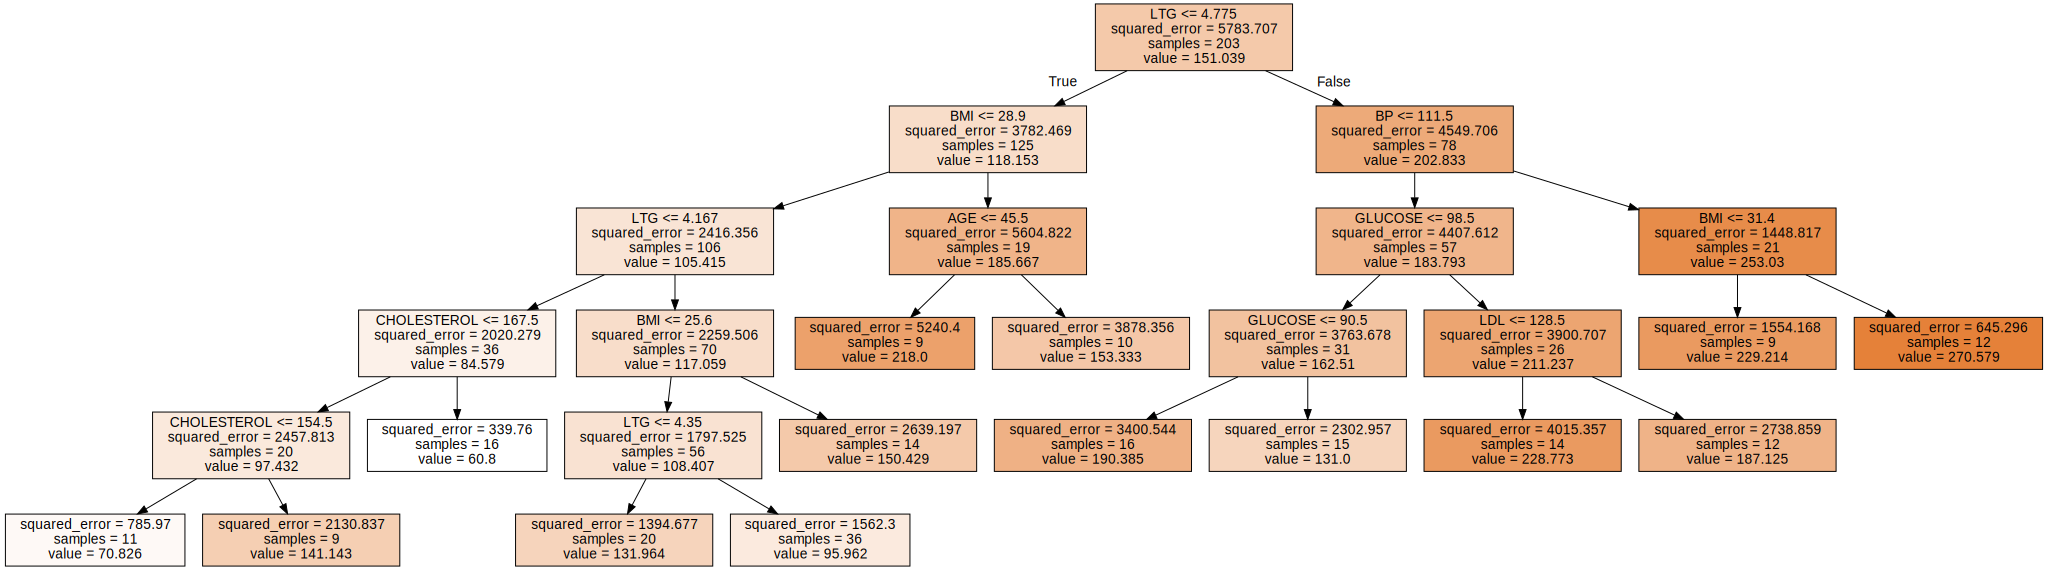

In [138]:
# 1번 트리 
export_graphviz(rf_final.estimators_[1], out_file='rf_final.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rf_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

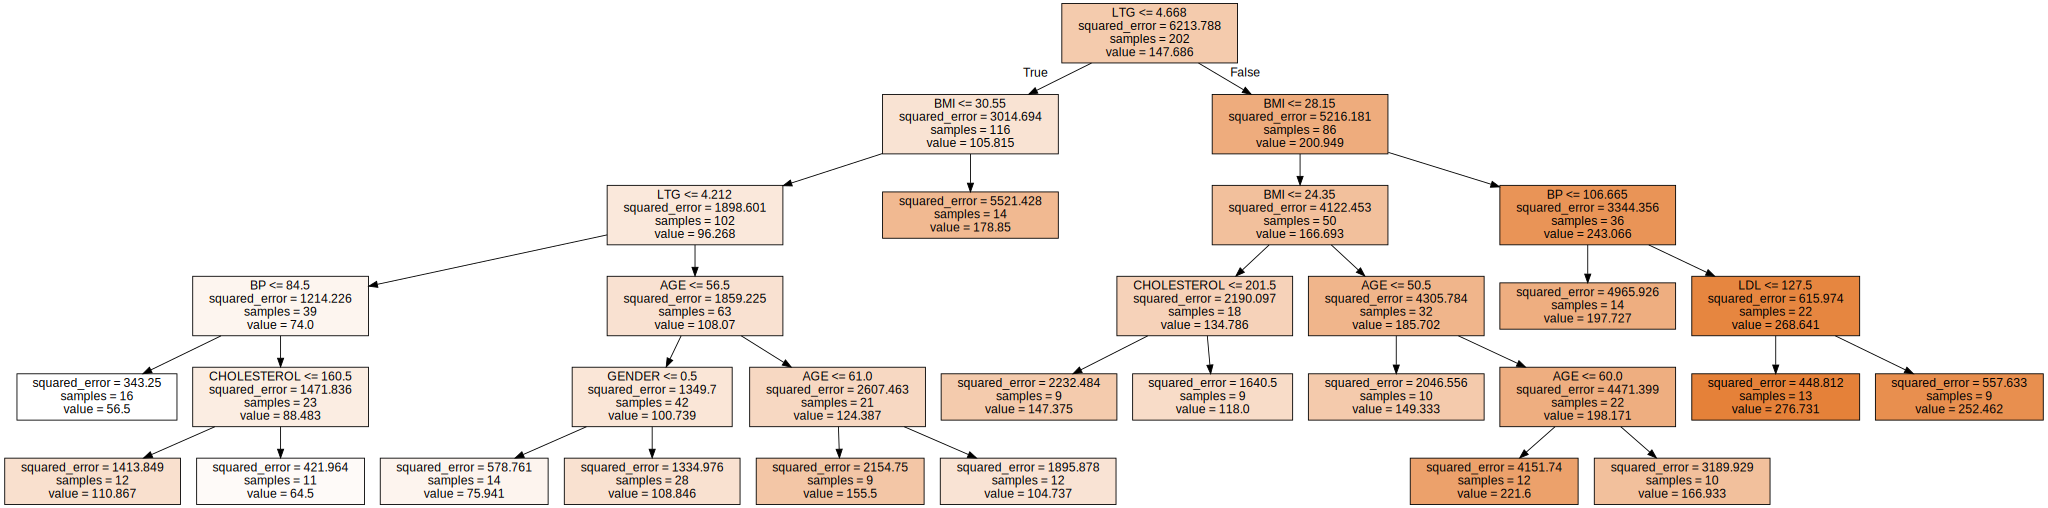

In [139]:
# 10번 트리 
export_graphviz(rf_final.estimators_[10], out_file='rf_final.dot', feature_names=v_feature_name, impurity=True, filled=True)
with open('rf_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

- 위와 같은 트리 100개를 조합하여 최종 모델이 생성된다. 

#### Step 4. 결론 도출 

In [140]:
# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

# 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.405
8,LTG,0.313
3,BP,0.117
6,HDL,0.034
5,LDL,0.032
0,AGE,0.030
9,GLUCOSE,0.028
4,CHOLESTEROL,0.019
7,TCH,0.016
1,GENDER,0.006


/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing f

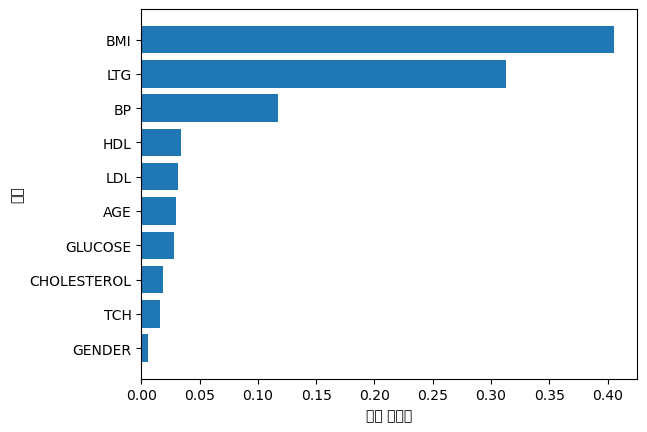

In [141]:
# 설명변수 중요도 그래프
# 중요도 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.show()

- BMI, LTG, BP 순으로 중요도가 높다는 것을 알 수 있다. 
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다. 

### 실습 3

#### Step 2. Gradient Boosting 모델 생성 - Parmeter 조정/평가 

In [142]:
# 기본 옵션으로 모델 생성
gb_uncustomized = GradientBoostingRegressor(random_state=2024)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print('Score on training set : {:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print('Score on test set : {:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.879
Score on test set : 0.422


- 모델 설명력은 Train 87.9%, Test 42.2%로 모델은 Train 데이터에 과대적합되어있다.

In [143]:
# 현재 생성된 트리 모델의 옵션 확인 
gb_uncustomized.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 2024,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 모델 Parameter 조정 - 트리 수 변경 

In [144]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# n_estimators
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=2024, n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

In [145]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.518,0.395
1,20,0.658,0.443
2,30,0.721,0.448
3,40,0.762,0.449
4,50,0.791,0.444
5,60,0.818,0.445
6,70,0.836,0.441
7,80,0.850,0.436
8,90,0.865,0.422
9,100,0.879,0.422


Text(0.5, 0, 'n_estimators')

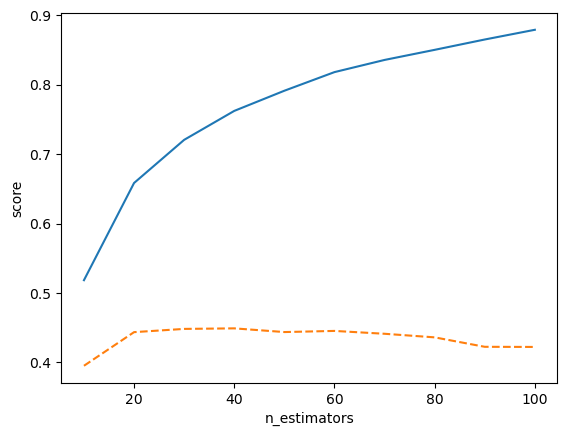

In [146]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle='-', label='Train Score')
plt.plot(para_n_tree, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('n_estimators')

- 트리 수 증가에 따라 모델은 설명력은 지속적으로 향상되고 있다. 
- Test 데이터의 성능 변화를 고려하여 40을 선택한다. 

##### 모델 Parameter 조정 - 잎사귀 노드의 최소 자료 수 변경 

In [147]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [148]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.879,0.422
1,2,0.874,0.400
2,3,0.869,0.402
3,4,0.871,0.405
4,5,0.866,0.410
5,6,0.857,0.422
6,7,0.849,0.406
7,8,0.849,0.434
8,9,0.841,0.424
9,10,0.829,0.434


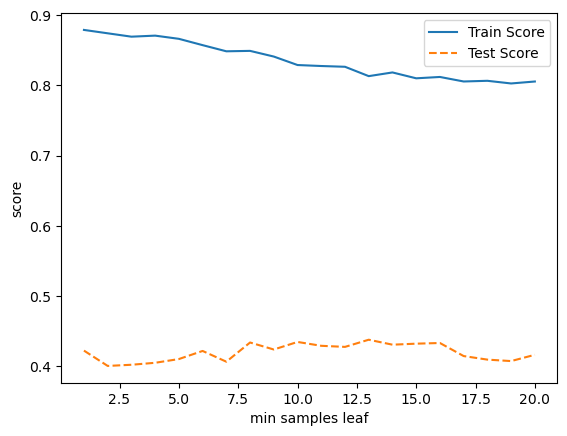

In [149]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle='-', label='Train Score')    
plt.plot(para_leaf, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('min samples leaf')
plt.legend()

- 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 
- Test 데이터의 성능 변화를 고려하여 13을 선택한다. 

##### 모델 Parameter 조정 - 분리 노드의 최소 자료 수 변경 

In [150]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split
para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=11, min_samples_split=v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

In [151]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.828,0.429
1,6,0.828,0.429
2,8,0.828,0.429
3,10,0.828,0.429
4,12,0.828,0.429
5,14,0.828,0.429
6,16,0.828,0.429
7,18,0.828,0.429
8,20,0.828,0.429
9,22,0.828,0.429


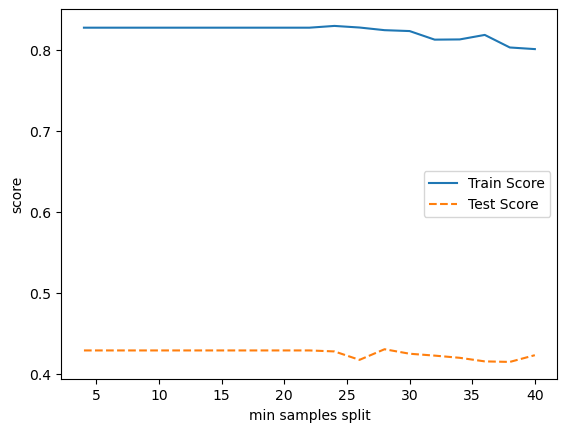

In [152]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle='-', label='Train Score')
plt.plot(para_split, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('min samples split')
plt.legend()

- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소한다. 
- Train/Test 데이터의 성능 변화를 고려하여 22을 선택한다. 
- 22보다 적은 영역에서는 변화가 없다. 

#####  모델 Parameter 조정 - 최대 깊이 변경 

In [153]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# max_depth
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=11, min_samples_split=22, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

In [154]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.590,0.474
1,2,0.719,0.445
2,3,0.828,0.429
3,4,0.908,0.422
4,5,0.939,0.379
5,6,0.960,0.373
6,7,0.972,0.398
7,8,0.978,0.372
8,9,0.979,0.368
9,10,0.982,0.369


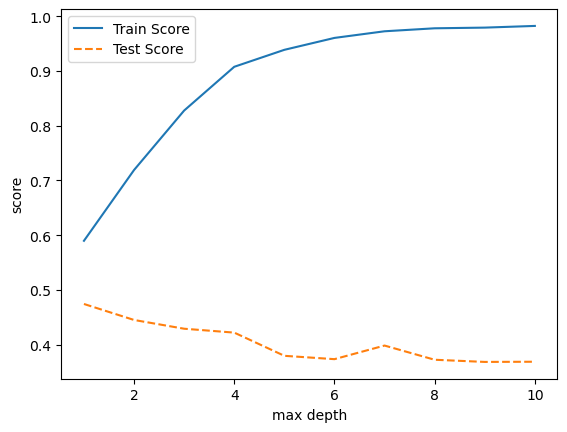

In [155]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle='-', label='Train Score')
plt.plot(para_depth, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('max depth')
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가한다. 
- Test 데이터의 성능 변화를 고려하여 4를 선택한다. 

##### 모델 Parameter 조정 - 학습률 변경 

In [156]:
# Train 및 Test 설명력 결과 저장
train_score = []
test_score = []
# learning_rate
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=11, min_samples_split=22, max_depth=3, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['TestScore'] = test_score

In [157]:
# 모델 설명력 확인
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.828,0.429
1,0.2,0.906,0.383
2,0.3,0.946,0.299
3,0.4,0.971,0.252
4,0.5,0.979,0.304
5,0.6,0.986,0.231
6,0.7,0.993,0.187
7,0.8,0.996,0.200
8,0.9,0.998,0.095


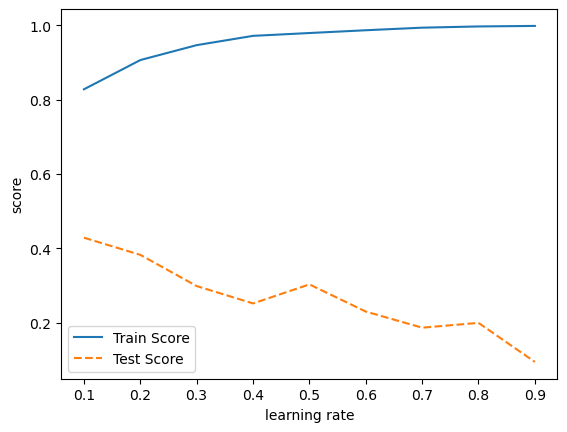

In [158]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle='-', label='Train Score')
plt.plot(para_lr, test_score, linestyle='--', label='Test Score')
plt.ylabel('score')
plt.xlabel('learning rate')
plt.legend()

- 학습률 증가에 따라 모델의 설명력은 증가한다. 
- Test 데이터의 성능은 급격하게 저하되어 0.1을 선택한다. 
- 0.1~0.2 사이의 세밀한 변화에 따른 성능 확인이 필요한 듯 보인다. 

#### Step 3. 최종 모델 선정/시각화 

In [159]:
# 최종 모델 생성 
# n_estimators=100, n_estimators=40, min_samples_leaf=13, min_samples_split=22, max_depth=4, learning_rate=0.1
gb_final = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=13, min_samples_split=22, max_depth=4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print('Score on training set : {:.3f}'.format(gb_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print('Score on test set : {:.3f}'.format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.889
Score on test set : 0.409


In [160]:
# 파라미터 확인
gb_final.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 13,
 'min_samples_split': 22,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 2024,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [161]:
# Test 데이터에 대한 실제값과 예측값 확인
test_pred = gb_final.predict(df_test_x)
print('test data의 실제값: \n', df_test_y[:10])
print('test data의 예측값: \n', test_pred[:10])

test data의 실제값: 
 334     72
313    163
133     83
152    292
250    303
320    122
66     150
35     102
161    217
149    126
Name: Y, dtype: int64
test data의 예측값: 
 [ 90.86064425 244.89514396  73.59716286 180.29382827 246.9898314
 148.81108681 133.95866197 122.84919433 242.78558865 162.76443418]


#### Step 4. 결론 도출 

In [162]:
v_feature_name = df_train_x.columns

# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

# 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,BMI,0.315
8,LTG,0.284
3,BP,0.103
0,AGE,0.062
6,HDL,0.061
9,GLUCOSE,0.059
5,LDL,0.056
4,CHOLESTEROL,0.033
7,TCH,0.014
1,GENDER,0.013


/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing f

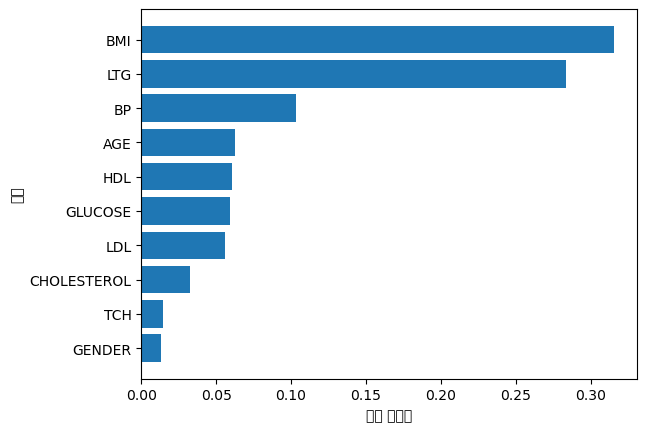

In [163]:
# 설명변수 중요도 그래프
# 중요도 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')
plt.show()

- BMI, LTG, BP 순으로 영향이 크다고 해석할 수 있다. 
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다. 

### 실습 1~3 결과 비교 

#### 모델 비교 

결정 트리 (Decision Tree)
- 단일 트리 구조로 데이터를 분류한다. 
- 이해와 해석이 쉽고, 시각화가 용이하다.
- 과적함 문제 발생 가능하다. 

랜덤 포레스트 (Random Forest)
- 여러 개의 결정 트리를 결합하여 예측 성능을 향상시킨다.
- 과적합을 방지하고, 높은 성능을 예측한다. 
- 상대적으로 학습 시간이 오래 걸린다.


그래디언트 부스팅 (Gradient Boosting)
- 일련의 약한 학습자를 결합하여 강한 학습자를 만든다. 
- 예측 정확도가 높고, 과적합을 방지한다. 
- 학습 시간이 길고, 파라미터 튜닝이 필요하다. 

#### 모델 성능 비교 

결정 트리 (Decision Tree)
- Train 데이터: 0.728
- Test 데이터: 0.327
- 하이퍼파라미터:
    - criterion: squared_error
    - 'max_depth': 4
    - 'min_samples_split': 20
    - 'min_samples_leaf': 6

랜덤 포레스트 (Random Forest)
- Train 데이터: 0.652
- Test 데이터: 0.448
- 하이퍼파라미터:
    - 'n_estimators': 100
    - 'max_depth': 5
    - 'min_samples_split': 9
    - 'min_samples_leaf': 9

그래디언트 부스팅 (Gradient Boosting)
- Train 데이터: 0.889
- Test 데이터: 0.409
- 하이퍼파라미터: 
    - 'learning_rate': 0.1
    - 'max_depth': 4
    - 'min_samples_split': 22
    - 'min_samples_leaf': 13

#### 변수 중요도 

모든 모델에서 BMI, LTG, BP 변수가 중요한 특징으로 나타났다. 

- 결정 트리     
    - BMI: 0.63
    - LTG: 0.23
    - BP: 0.14
- 랜덤 포레스트
    - BMI: 0.39
    - LTG: 0.36
    - BP: 0.15
- 그래디언트 부스팅
    - BMI: 0.31
    - LTG: 0.29
    - BP: 0.15

#### 결론

랜덤 포레스트와 그라디언트 부스팅 모델이 결정 트리보다 더 나은 성능을 보였다. 특히, 랜덤 포레스트 모델은 Test 데이터에서 가장 높은 점수를 기록하였다. 그러나, 그래디언트 부스팅 모델은 Train 데이터에서의 높은 성능과 함께 Test 데이터에서도 높은 성능을 보였기 때문에, 더 나은 파라미터 튜닝과 함께 사용된다면 잠재적으로 가장 좋은 성능을 낼 수 있을 것으로 보인다. 

현재는, 각 모델의 특징과 성능을 고려할 때, 랜덤 포레스트 (Random Forest)가 당뇨병 데이터셋에 대해 가장 적합한 모델로 판단된다. 

### 실습 4

#### Step 2. 예측 모델 생성 (회귀분석, 의사결정나무, 랜덤 포레스트, 그래디언트 부스팅)

In [164]:
# 회귀 모델 
lr_model = smf.ols(formula='Y ~ BMI + LTG + BP', data=df_raw)
lr_result = lr_model.fit()
print(lr_result.summary())

# Decision Tree 모델
dt_model = DecisionTreeRegressor(random_state=2024, min_samples_leaf=9, min_samples_split=9, max_depth=2)
dt_model.fit(df_train_x, df_train_y)

# Random Forest 모델
rf_model = RandomForestRegressor(random_state=2024, n_estimators=100, min_samples_leaf=9, min_samples_split=9, max_depth=5)
rf_model.fit(df_train_x, df_train_y)

# Gradient Boosting 모델
gb_model = GradientBoostingRegressor(random_state=2024, n_estimators=100, min_samples_leaf=13, min_samples_split=22, max_depth=4, learning_rate=0.1)
gb_model.fit(df_train_x, df_train_y)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     134.8
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           7.16e-62
Time:                        23:23:39   Log-Likelihood:                -2402.6
No. Observations:                 442   AIC:                             4813.
Df Residuals:                     438   BIC:                             4830.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -334.8812     25.878    -12.941      0.0

GradientBoostingRegressor(max_depth=4, min_samples_leaf=13,
                          min_samples_split=22, random_state=2024)

#### Step 3. 예측 및 평가 

In [165]:
# 모델 리스트, 그래프를 그리기 생성 목적 
models = ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting"]
# 평가 리스트 초기화 
mse, rmse, mae, mape = [], [], [], []

##### 회귀분석 

In [166]:
# 예측 
lr_y_pred = lr_result.predict(df_test_x)

# 평가 
mse.append(mean_squared_error(df_test_y, lr_y_pred))
rmse.append(np.sqrt(mean_squared_error(df_test_y, lr_y_pred)))
mae.append(mean_absolute_error(df_test_y, lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, lr_y_pred))

##### 의사결정나무

In [167]:
# 예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가 
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(np.sqrt(mean_squared_error(df_test_y, dt_y_pred)))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

##### 랜덤포레스트

In [168]:
# 예측 
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(np.sqrt(mean_squared_error(df_test_y, rf_y_pred)))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

##### 그래디언트 부스팅 

In [169]:
# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(np.sqrt(mean_squared_error(df_test_y, gb_y_pred)))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

#### Step 4. 시각화 

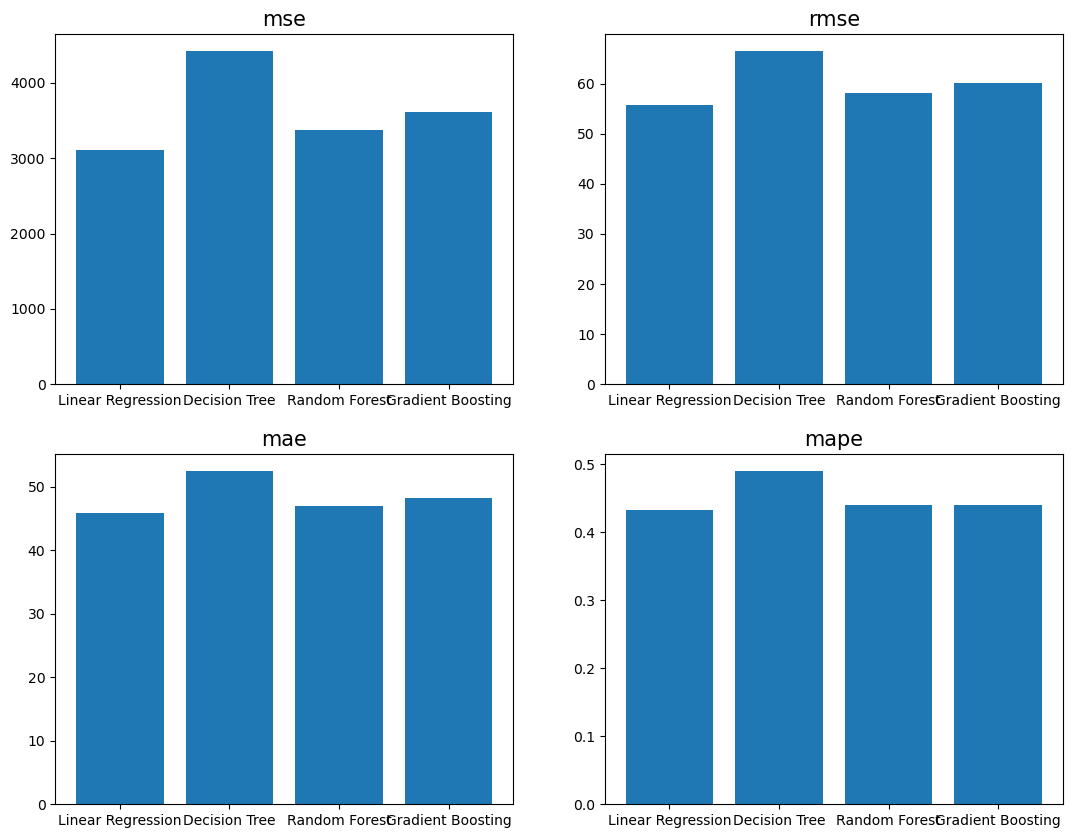

In [170]:
# 평가 
fig, ax = plt.subplots(2,2, figsize=(13,10))

ax[0,0].bar(models, mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title('mape').set_fontsize(15)

#### 결론

- MSE (Mean Squared Error):
    - 선형 회귀 (Linear Regression)는 MSE가 약 3000으로 가장 낮다.
    - 의사결정 나무 (Decision Tree)는 MSE가 약 4500으로 가장 높아 성능이 가장 미흡하다.
    - 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting)은 약 3500-4000 사이로 비슷한 성능을 보인다.

- RMSE (Root Mean Squared Error):
    - RMSE 지표에서도 선형 회귀 (Linear Regression)는 가장 낮은 값을 가지며, 의사결정 나무 (Decision Tree)는 가장 높은 값을 가진다.
    - 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting)의 성능은 유사하다.

- MAE (Mean Absolute Error):
    - 선형 회귀 (Linear Regression)는 MAE가 약 40으로 가장 낮다.
    - 의사결정 나무 (Decision Tree)는 약 50으로 가장 높은 MAE 값을 가진다.
    - 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting)은 약 45-48 사이로 비슷한 성능을 보인다.

- MAPE (Mean Absolute Percentage Error):
    - 선형 회귀 (Linear Regression)는 MAPE가 약 0.4로 가장 낮다.
    - 의사결정 나무 (Decision Tree)는 약 0.5로 가장 높은 MAPE 값을 가진다.
    - 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting)은 약 0.45로 비슷한 성능을 보인다.

종합적으로 보았을 때, 선형 회귀 (Linear Regression) 모델이 모든 평가지표에서 가장 우수한 성능을 보이며, 의사결정 나무 (Decision Tree) 모델이 가장 낮은 성능을 보인다. 랜덤 포레스트 (Random Forest)와 그래디언트 부스팅 (Gradient Boosting) 모델은 대체로 비슷한 성능을 보인다. 각 모델의 성능은 전반적으로 일관된 경향을 보이고 있다.